Imports of stuff we need

In [158]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Load the $B_c^+ \to \tau^+ \nu_\tau$ simulation with $\tau^+ \to 3\pi \nu_\tau$

In [126]:
file = uproot.open("/eos/experiment/fcc/ee/tmp/flatntuples/Z_Zbb_Bc2TauNu/events_Bc2TauNu.root")
tree = file['events']

Load tree contents into awkward array

In [ ]:
events = tree.arrays(library="ak", how="zip")
tree.show()

Access the reconstructed particles, and match them to their MC partners. Also calculate the separation of the particle production vertices from the PV, used to calculate combined $B_c$ + $\tau$ flight

In [ ]:
#Reco particles
rp = events["RP"]

#Index cut to remove negative indices (particles produced before hadronisation)
parentindex_cut = rp["MC_parentindex"] >= 0
rp = rp[parentindex_cut]
grandparentindex_cut = rp["MC_grandparentindex"] >= 0
rp = rp[grandparentindex_cut]

#Match to MC truth partners
rp["parent_pdg"] = events["MC","pdg"][rp["MC_parentindex"]]
rp["grandparent_pdg"] = events["MC","pdg"][rp["MC_grandparentindex"]]

#Get the production vertex of the track
for v in ["x","y","z"]:
    rp[f"vertex_{v}"] = events["MC",f"vertex_{v}"][rp["MC_index"]] 

#Separation of vertex from PV (combined tau and Bc flight)
rp["PVsep"] = np.sqrt(rp[f"vertex_x"]**2 + rp[f"vertex_y"]**2 + rp[f"vertex_z"]**2)

Grab the pions based on their true mass (perfect PID)

In [ ]:
#Pions
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pions = rp[pi_cut]
p_cut = pions["p"] > 0.
pions = pions[p_cut]

Combine three pions to make a $\tau$ candidate, and require correct charge combinations. Also apply truth matching to ensure $\tau$ parent and $B_c$ grandparent.

In [130]:
#Build the tau -> 3pi
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

#Truth-matching

#Pion parents are all tau
tau_parent_cut_pi1 = abs(tau["pi_1"]["parent_pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_pi2 = abs(tau["pi_2"]["parent_pdg"]) == abs(lp.tau_plus.pdgid) 
tau_parent_cut_pi3 = abs(tau["pi_3"]["parent_pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_12 = np.logical_and(tau_parent_cut_pi1, tau_parent_cut_pi2)
tau_parent_cut_all = np.logical_and(tau_parent_cut_12, tau_parent_cut_pi3)
tau = tau[tau_parent_cut_all]

#Pion grandparent are all Bc
tau_grandparent_cut_pi1 = abs(tau["pi_1"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid)
tau_grandparent_cut_pi2 = abs(tau["pi_2"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid) 
tau_grandparent_cut_pi3 = abs(tau["pi_3"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid)
tau_grandparent_cut_12 = np.logical_and(tau_grandparent_cut_pi1, tau_grandparent_cut_pi2)
tau_grandparent_cut_all = np.logical_and(tau_grandparent_cut_12, tau_grandparent_cut_pi3)
tau = tau[tau_grandparent_cut_all]

#Ensure pions come from the same tau
tau_parent_cut_12 = tau["pi_1","MC_parentindex"] == tau["pi_2","MC_parentindex"]
tau_parent_cut_13 = tau["pi_1","MC_parentindex"] == tau["pi_3","MC_parentindex"]
tau_parent_cut = np.logical_and(tau_parent_cut_12, tau_parent_cut_13)
tau = tau[tau_parent_cut]

#Net charge of the tau
tau["charge"] = tau["pi_1","charge"] + tau["pi_2","charge"] + tau["pi_3","charge"]

#Tau energy (visible energy of the signal)
for comp in ["x","y","z"]:
    tau[f"p{comp}"] = tau["pi_1",f"p{comp}"] + tau["pi_2",f"p{comp}"] + tau["pi_1",f"p{comp}"]
tau["p"] = np.sqrt(tau["px"]**2 + tau["py"]**2 + tau["pz"]**2)
tau["e"] = np.sqrt(tau["mass"]**2 + tau["p"]**2)

Calculate the total energy in each hemisphere, and split into minimum and maximum hemisphere energies

In [131]:
#Hemisphere energies
for hem in ["0","1"]:
    events[f"EVT_thrutshemis{hem}_e"] = events[f"EVT_thrutshemis{hem}_echarged"] + events[f"EVT_thrutshemis{hem}_eneutral"]

#Total energy (sum of both hemispheres)
events["EVT_e"] = events["EVT_thrutshemis0_e"] + events["EVT_thrutshemis1_e"]

#Min and max hemisphere energies per-event
events["EVT_thrutshemis_e_min"] = np.minimum(events["EVT_thrutshemis0_e"],events["EVT_thrutshemis1_e"])
events["EVT_thrutshemis_e_max"] = np.maximum(events["EVT_thrutshemis0_e"],events["EVT_thrutshemis1_e"])

#Difference in energy between hemispheres (max - min so always positive)
events["EVT_thrutshemis_e_diff"] = events["EVT_thrutshemis_e_max"] - events["EVT_thrutshemis_e_min"]

Plot the energies for the minimum and maximum energy hemispheres

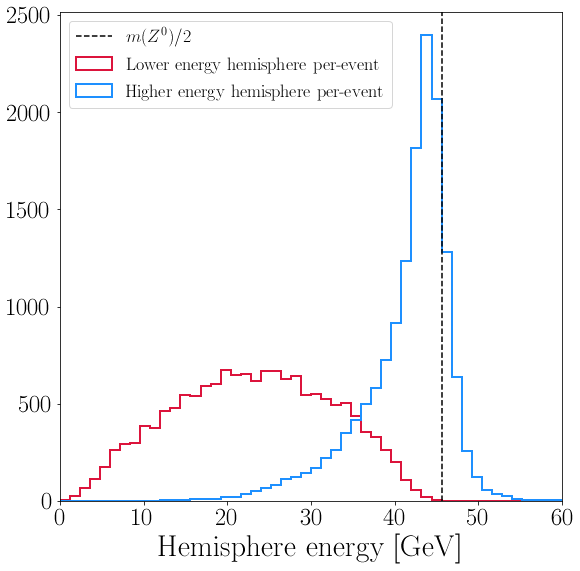

In [132]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(events["EVT_thrutshemis_e_min"],bins=50,range=(0,60),color="crimson",histtype='step',linewidth=2,label="Lower energy hemisphere per-event")
plt.hist(events["EVT_thrutshemis_e_max"],bins=50,range=(0,60),color="dodgerblue",histtype='step',linewidth=2,label="Higher energy hemisphere per-event")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,60)
plt.axvline(lp.Z_0.mass/2000., color='k',linestyle='--',label="$m(Z^0)/2$")
plt.xlabel("Hemisphere energy [GeV]",fontsize=30)
plt.legend(fontsize=18, loc="upper left")
plt.show()

Plot the energy difference (max - min) for the two hemispheres

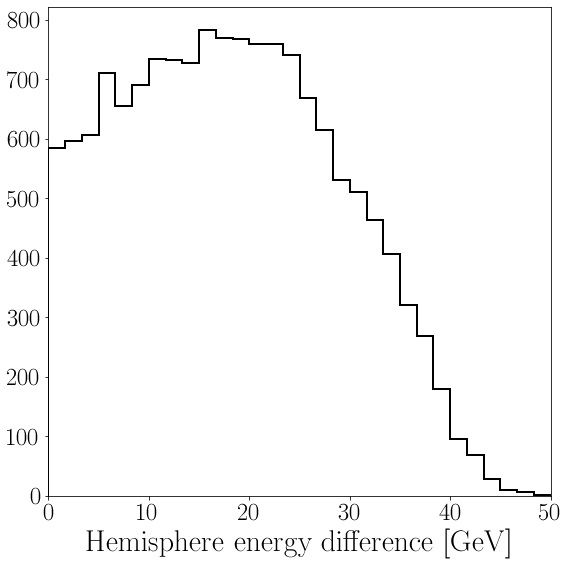

In [133]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(events["EVT_thrutshemis_e_diff"],bins=30,range=(0,50),color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,50)
plt.xlabel("Hemisphere energy difference [GeV]",fontsize=30)
plt.show()

Plot the two hemisphere energies vs. each other. We are plotting hemisphere 0 (opposite thrust axis direction) and hemisphere 1 (along thrust axis direction) here, rather than the min and max energy hemispheres. The plot shows that the two hemispheres are largely independent. 

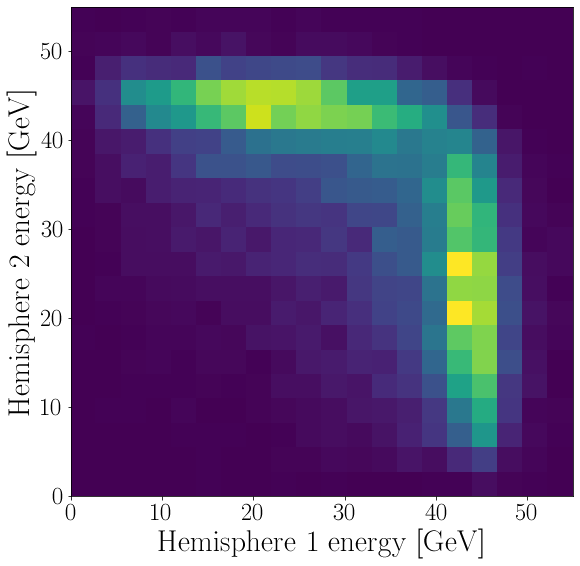

In [134]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist2d(events["EVT_thrutshemis0_e"].tolist(),events["EVT_thrutshemis1_e"].tolist(),bins=20,range=[[0,55],[0,55]])
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel("Hemisphere 1 energy [GeV]",fontsize=30)
plt.ylabel("Hemisphere 2 energy [GeV]",fontsize=30)
plt.show()

Split the tau candidates into two hemispheres according to angle with thrust axis. For each set, check that their hemisphere energy in the minimum one in the event. Then recombine into a total sample.

In [135]:
#Determine hemisphere that the tau candidate falls in
tau["EVT_e"] = events["EVT_e"]

#costheta > 0 belong to hemisphere 1
tau_hem1_cut = tau["pi_1","thrustangle"] >= 0
tau_hem1 = tau[tau_hem1_cut]
tau_hem1["hem_e"] = events["EVT_thrutshemis1_e"]

tau_hem2_cut = tau["pi_1","thrustangle"] < 0
tau_hem2 = tau[tau_hem2_cut]
tau_hem2["hem_e"] = events["EVT_thrutshemis0_e"]

#Require that the tau hemisphere energies are the minimum ones
tau_hem1_e_cut = tau_hem1["hem_e"] == events["EVT_thrutshemis_e_min"]
tau_hem1 = tau_hem1[tau_hem1_e_cut]

tau_hem2_e_cut = tau_hem2["hem_e"] == events["EVT_thrutshemis_e_min"]
tau_hem2 = tau_hem2[tau_hem2_e_cut]

tau = ak.concatenate([tau_hem1,tau_hem2],axis=0)

Calculate the nomimal $B$ energy for each $\tau$ candidate. This is given by $m(Z) - \Sigma$(all of the visible energy in the event apart from the signal $3\pi$). On average this variable will be small for inclsuive $Z \to q\bar{q}$ because the total energy will peak near $m(Z)$. But for signal events with significant missing energy, the distribution is displaced to higher values.

In [136]:
#Nominal B energy = m(Z) - sum of all energy apart from signal
tau["nominal_B_e"] = lp.Z_0.mass/1000. - (tau["EVT_e"] - tau["e"])

Plot the nominal $B$ energy 

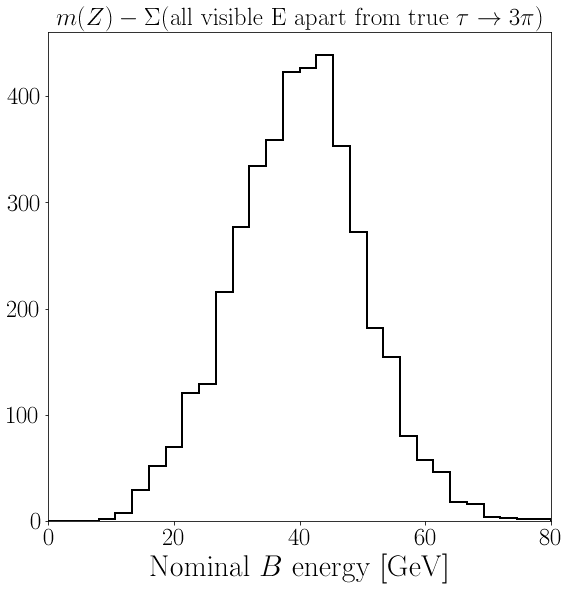

In [139]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(ak.flatten(tau["nominal_B_e"]),range=(0,80),bins=30,color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.title("$m(Z) - \\Sigma$(all visible E apart from true $\\tau \\to 3\\pi$)",fontsize=25)
plt.xlim(0,80)
plt.xlabel("Nominal $B$ energy [GeV]",fontsize=30)
plt.show()

Plot the $m(3\pi)$ distribution for truth-matched $\tau$'s.

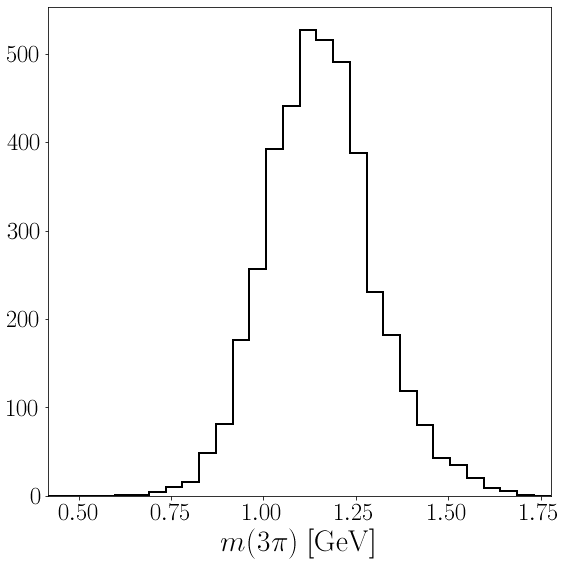

In [140]:
#Plot the tau mass for truth-matched signal
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(ak.flatten(tau["mass"]),range=(tau_m_low_cut_val,tau_m_high_cut_val),bins=30,color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(tau_m_low_cut_val,tau_m_high_cut_val)
plt.xlabel("$m(3\\pi)$ [GeV]",fontsize=30)
plt.show()

Determine the charged and neutral total energies and multiplicities in the low and high energy hemispheres. Do this by splitting the sample into two, where hemisphere 0 or 1 is the lower energy one. Then grab the charged and neutral variable values for the corresponding hemispheres. At the end recombine the sample.

In [145]:
#Look at charged and neutral multiplicities in the two hemispheres

#Events where hemisphere 0 is the minimum energy
events_hem0_min_cut = events["EVT_thrutshemis0_e"] == events["EVT_thrutshemis_e_min"]
events_hem0_min = events[events_hem0_min_cut]

#Events where hemisphere 1 is the minimum energy
events_hem1_min_cut = events["EVT_thrutshemis1_e"] == events["EVT_thrutshemis_e_min"]
events_hem1_min = events[events_hem1_min_cut]

#Get the charged and neutral energy and multiplicity
for ptype in ["charged","neutral"]:
    for var in ["n","e"]:
        events_hem0_min[f"{var}{ptype}_min"] = events_hem0_min[f"EVT_thrutshemis0_{var}{ptype}"]
        events_hem0_min[f"{var}{ptype}_max"] = events_hem0_min[f"EVT_thrutshemis1_{var}{ptype}"]
        
        events_hem1_min[f"{var}{ptype}_min"] = events_hem1_min[f"EVT_thrutshemis1_{var}{ptype}"]
        events_hem1_min[f"{var}{ptype}_max"] = events_hem1_min[f"EVT_thrutshemis0_{var}{ptype}"]

#Recombine
events = ak.concatenate([events_hem0_min,events_hem1_min],axis=0)

Plot the charged and neutral energies and multiplicities, where the low and high energy hemispheres are shown separately. These plots demonstrate that the signal (low energy) and non-signal sides are different in terms of their full event information. This can be used along with the hemisphere energy and nominal $B$ energy above inside an isolation MVA to distinguish signal from $Z \to q \bar{q}$.

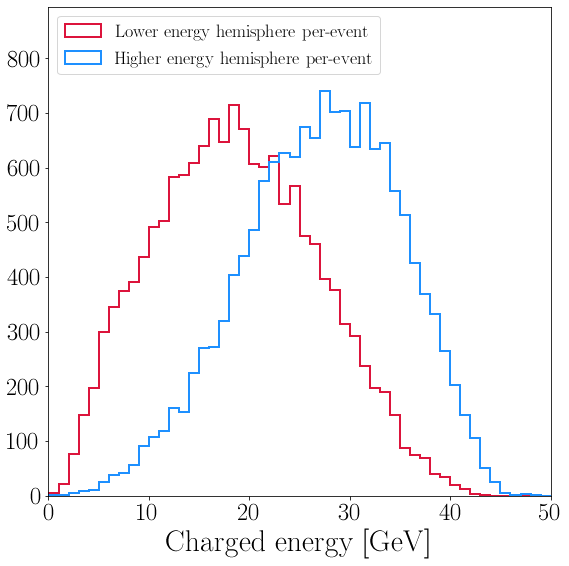

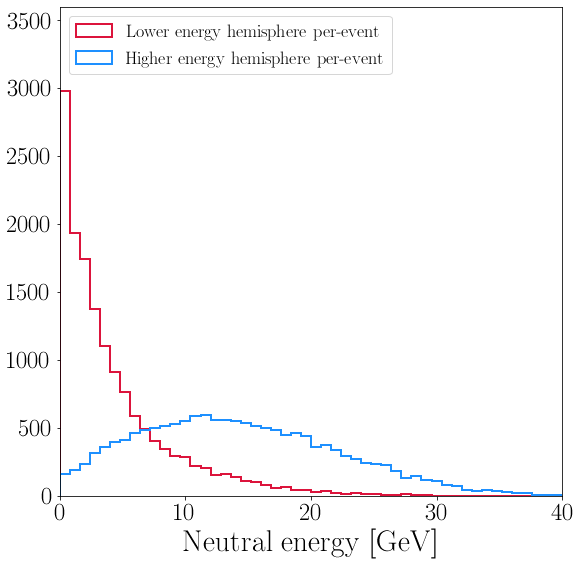

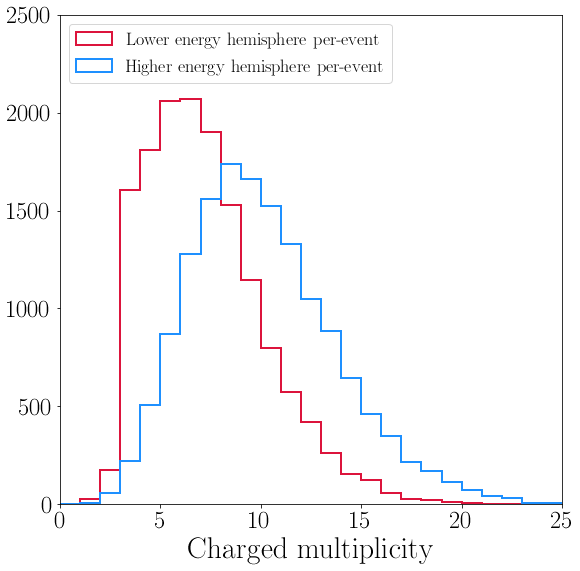

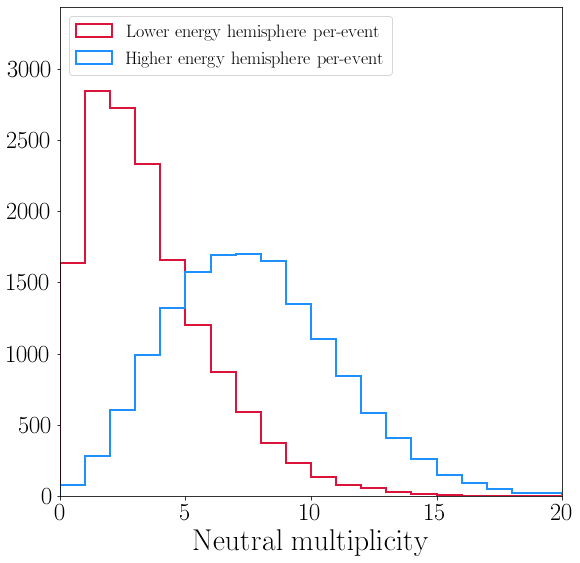

In [160]:
#Axis ranges, titles, and bins
plot_config = {"echarged": [0,50,"Charged energy [GeV]",50],
              "eneutral": [0,40,"Neutral energy [GeV]",50],
              "ncharged": [0,25,"Charged multiplicity",25],
              "nneutral": [0,20,"Neutral multiplicity",20]
              }

for p in plot_config:

    fig, ax = plt.subplots(figsize=(9,9))
    plt.hist(events[f"{p}_min"],bins=plot_config[p][3],range=(plot_config[p][0],plot_config[p][1]),color="crimson",histtype='step',linewidth=2,label="Lower energy hemisphere per-event")
    plt.hist(events[f"{p}_max"],bins=plot_config[p][3],range=(plot_config[p][0],plot_config[p][1]),color="dodgerblue",histtype='step',linewidth=2,label="Higher energy hemisphere per-event")
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.xlim(plot_config[p][0],plot_config[p][1])
    plt.xlabel(plot_config[p][2],fontsize=30)
    ymin,ymax = plt.ylim()
    plt.ylim(0,1.15*ymax)
    plt.legend(fontsize=18, loc="upper left")
    plt.show()